# A study on spontaneous decay rate of an atom in presence of a nanofiber using BEM approach

In these notes, I calculate the Local Density of States (LDOS), or the imaginary part of the on-site Green's function and hence the modified spontaneous emission rate of an atom in presence of a nanofiber using the Boundary Element Method (BEM). The BEM code is from Prof. Alejandro Manjavacas's group. 

This is an [IJulia notebook](https://github.com/JuliaLang/IJulia.jl), which provides a nice
browser-based [Jupyter](http://jupyter.org/) interface to the [Julia language](http://julialang.org/), a high-level dynamic language (similar to Matlab or Python+SciPy) for technical computing.  The notebook allows us to combine code and results in one place.

We are only manipulating the generated data from the simulation results in this notebook. As a brief recap of the simulation process, I have used a compiled BEM code by Alejandro's group written in C++ called `bem2D` on a cluster computing system. A configuration C++ code is defined in the file `scripts_ldos.cpp` which is in the same folder as `bem2D`. I compiled the script and put the generated executable into another folder called `p21`, for example, by
```
g++ scripts_ldos.cpp -lstdc++ -o ../p21/scripts_ldos
```
Then ran the executable and submitted the generated PBS script to the cluster system to run the simulation:
```
cd ../p21/
./scripts_ldos
qsub ldos_N_1_lam_894_eps_4_0_a_225_x_405_y_0_q_0_1.45_146.pbs
```
Notice that the name of the PBS script is automatically generated based on the configuration parameters for this simulation. The name will vary for different simulations. After running the script, I got a set of data files--one has the same name as the PBS script but with a `.dat` extension for the data table storing the calculated LDOS values; there are another two `*.dat` files for the geometry of boundary and dieletric function distribution. We will look into those data files in the following sections.


## 3D dielectric waveguide simulated in 2D

Just a little more detail on the simulation itself: By assuming the waveguide along z-axis or the light propagation direction is uniform, one can completely solve the boundary condition problem of dipole emission by simulating the field in one single layer of the xy cross section. The z-component of the field only adds in a phase factor. The data of the simulated result is stored in the /data/ folder of this repo. 

We can read in this data as a matrix of numbers by the `readdlm` function in Julia with the `header=false` option meaning that it reads the first line as the beginning of the data entries without a list of strings describing each column.

Now, let's plot the results.  I'll use the [PyPlot](https://github.com/stevengj/PyPlot.jl) package in Julia, which is an interface to the sophisticated [matplotlib](http://matplotlib.org/) Python plotting library.   We'll plot three things:

* The waveguide structure in terms of $\epsilon$ and the interface boundary between two media.
* Plot the LDOS components for a fixed dipole position.
* Calculate the waveguide-modified spontaneous decay rate when the dipole varies its position outside of the waveguide.



### Plotting the boundary and index of refraction profile of the waveguide in the xy cross section

Our boundary points are meshed in the files `/data/geom_a_225.data` and `/data/geom_regions_a_225.data`, which positions where the equivalent charges and current sources to be computed in the BEM simulation. The waveguide has a circular cross-section of a radius $a=225nm$ ($nm$ is the unit of length) and a index of refraction of $n_1=n_{core}=1.4496$ for the waveguide material and $n_2=n_{clad}=1$ for the vacuum clad. 

It is good to plot out the mesh of index of refraction in space and find out how good is the mesh resolution. This can be done by plotting out the output eps file in a simple data table format, which ends in `.dat`. 

The following will first print out some of the data in order to figure out the physics meaning of the dimensions. They should contain the coordinate and index of refraction information for the simulation.

In [1]:
boundary = readdlm("data/geom_regions_a_225.dat", header=false);
boundarypoints = boundary[:,1:3]

10201×3 Array{Float64,2}:
 -269.999  -269.998  1.0
 -269.999  -264.599  1.0
 -269.999  -259.199  1.0
 -269.999  -253.799  1.0
 -269.999  -248.399  1.0
 -269.999  -242.999  1.0
 -269.999  -237.599  1.0
 -269.999  -232.199  1.0
 -269.999  -226.799  1.0
 -269.999  -221.399  1.0
 -269.999  -215.999  1.0
 -269.999  -210.599  1.0
 -269.999  -205.199  1.0
    ⋮                   
  269.994   210.599  1.0
  269.994   215.999  1.0
  269.994   221.399  1.0
  269.994   226.799  1.0
  269.994   232.199  1.0
  269.994   237.599  1.0
  269.994   242.999  1.0
  269.994   248.399  1.0
  269.994   253.799  1.0
  269.994   259.199  1.0
  269.994   264.599  1.0
  269.994   269.998  1.0

In [2]:
epsilon3D = readdlm("data/geom_a_225.dat", header=false);
epsilon2Dpoints = epsilon3D[:,[1,2,4]]

471×3 Array{Float64,2}:
 224.995    1.50075  1.0
 224.955    4.50198  1.0
 224.875    7.50241  1.0
 224.755   10.5015   1.0
 224.595   13.4987   1.0
 224.395   16.4936   1.0
 224.155   19.4855   1.0
 223.875   22.4739   1.0
 223.555   25.4583   1.0
 223.196   28.4382   1.0
 222.796   31.413    1.0
 222.358   34.3823   1.0
 221.879   37.3454   1.0
   ⋮                    
 222.358  -34.3823   1.0
 222.796  -31.413    1.0
 223.196  -28.4382   1.0
 223.555  -25.4583   1.0
 223.875  -22.4739   1.0
 224.155  -19.4855   1.0
 224.395  -16.4936   1.0
 224.595  -13.4987   1.0
 224.755  -10.5015   1.0
 224.875   -7.50241  1.0
 224.955   -4.50198  1.0
 224.995   -1.50075  1.0

Now we plot out the data in a 2D (xy) plane. 

269.999

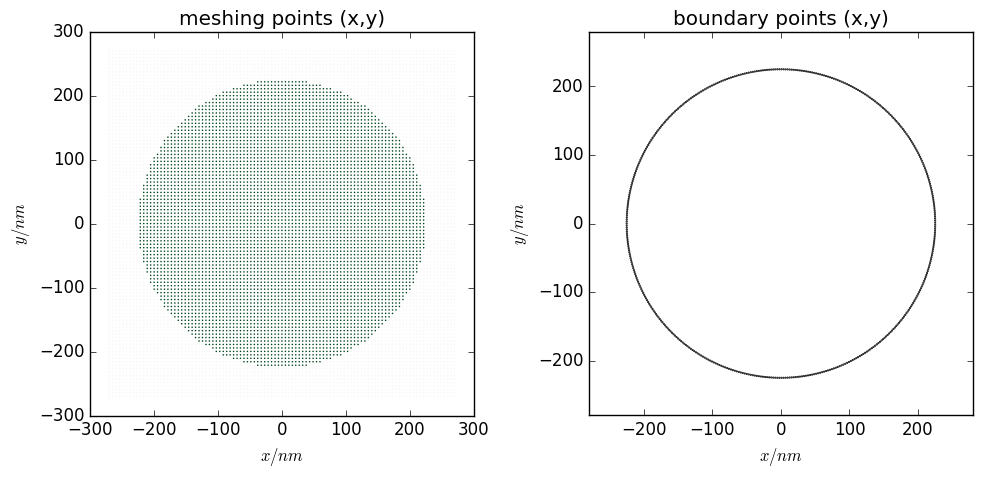

In [3]:
using PyPlot
#println(convert(Int64,floor(lenz/2)))
x = boundarypoints[:,1];
y = boundarypoints[:,2];
v_regions = boundarypoints[:,3];
lenx = length(x)

fig = figure("Boundary points plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
c = get_cmap("PRGn")
rgbs = [c(norm(value/2.)) for value in v_regions]
scatter(x,y,c=rgbs,linewidths=0,marker=".",s=5)

xlabel(L"x/nm")
ylabel(L"y/nm")
axis("image")
xlim(-300,300)
ylim(-300,300)
tight_layout()
title("meshing points (x,y)");
display(maximum(abs(x)))

subplot(1,2,2)
x_eps = epsilon2Dpoints[:,1]; y_eps = epsilon2Dpoints[:,2]; v_eps = epsilon2Dpoints[:,3];
ax = fig[:add_subplot](1,2,2)
c = get_cmap("Greys")
rgbs = [c(norm(value/2.)) for value in v_eps]
scatter(x_eps,y_eps,c=rgbs, marker = :.,s=1)

xlabel(L"x/ nm")
ylabel(L"y/ nm")
axis("image")
xlim(-280,280)
ylim(-280,280)
tight_layout()
#gcf() # Needed for IJulia to plot inline
title("boundary points (x,y)");

The first plot only shows the 101$\times$101 data points, in which the plotted area is the computing region of a $270nm\times 270nm$ square with the nanofiber region colored in green. The figure on the right covers the boundary points pretty densely, although the point overlap at the $(225,0)nm$ location is not visible.


# Plotting the LDOS components with a fixed dipole position

To calculate the modified decay rates, we need to use the LDOS value at the dipole position. The result is calculated at a series of $k$ points. I expect to see a continuous positive curve when $k\in [0,1]\omega/c$ or in the radiative mode regime and a single positive spark in the $[1,1.45]\omega/c$ or guided mode regime--given the waveguide is a single-mode glass fiber.

1.0589

1.0589

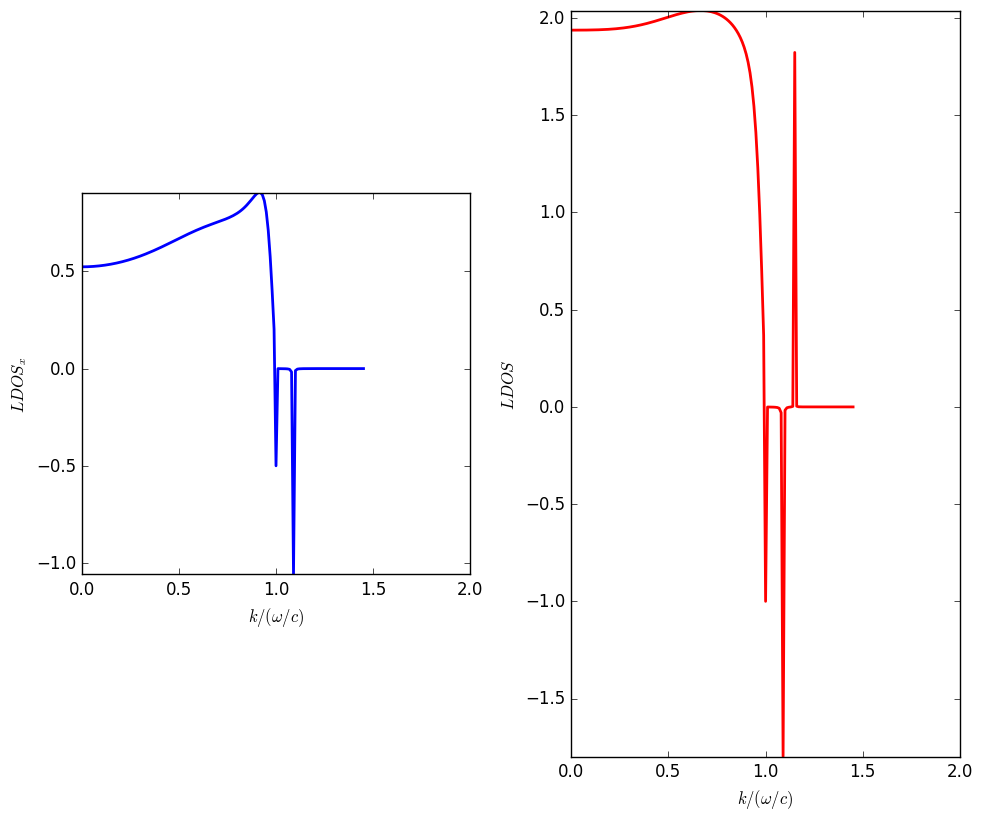

In [4]:
ldos = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
ldosqpoints = ldos[:,[2,5,6,7,8]]
using PyPlot
#println(convert(Int64,floor(lenz/2)))
q = ldosqpoints[:,1]
ldosx = ldosqpoints[:,2]
ldosy = ldosqpoints[:,3]
ldosz = ldosqpoints[:,4]
ldos_av = ldosqpoints[:,5]
lenx = length(q)

fig = figure("LDOS q plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
cp = ax[:plot](q, ldosx, "b-", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS_x")
axis("image")
xlim(-0.0,2)
#ylim(-300,300)
tight_layout()
gcf() # Needed for IJulia to plot inline
display(maximum(abs(ldosx)))

ax = fig[:add_subplot](1,2,2)
cp = ax[:plot](q, ldos_av, "r-", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS")
axis("image")
xlim(-0.0,2)
#ylim(-300,300)
tight_layout()
gcf() # Needed for IJulia to plot inline
display(maximum(abs(ldosx)))

As you can see, ***there are negative sparks in the guided mode regime***. It could be a numerical error in the code and may be removed using some tricks.

Now we can integrate the $\mathrm{LDOS}_i$ values over $k$ along the whole axis to obtain the total decay rate or from $0$ to $\omega/c$ to obtain the radiative mode contribution for the decay rate. Each integral can be performed as a sum over all discrete points along the $k$-axis using the Trapezoid approximation as below:
$$\begin{align}\int \mathrm{LDOS}_i(k)dk &= \sum_{j=1,\cdots,N-1} \frac{\mathrm{LDOS}_i(k_j)+\mathrm{LDOS}_i(k_j+1)}{2}\Delta k\\
&= \left(\frac{\mathrm{LDOS}_i(k_N)+\mathrm{LDOS}_i(k_N)}{2}+\sum_{j=2,\cdots,N-1}\mathrm{LDOS}_i(k_j)\right)\Delta k,\end{align}$$
where $N$ is the total number of data points along the $k$-axis, and $\Delta k=k_j-k_{j-1}=k_2-k_1$ as the interval of $k$-vector in a uniform distribution manner.

In our case, the integrand is discontinuous and breaks the continuity at $k=k_0=\omega/c$ point. Therefore, we divide our integration limit into the $[0,n_2)k_0$ and $(n_2,n_1]k_0$ two regions corresponding to radiation mode contribution and guided mode contribution parts, where $n_2=1$ is the index of refraction of the vacuum clad and $n_1=1.4496$ is the index of refraction of the waveguide bulk material. Since there are surdden jumps in the guided mode regime, the integration may have some error using current method, but it shouldn't be too large as the jumps are in small intervals.

In [5]:
length_of_q=length(ldosqpoints[:,1])
breakpoint = Int(floor((length_of_q-1)/maximum(ldosqpoints[:,1])*1.)) # The breaking point of index is chosen under the fact that the radiation contribution part takes a half space for $n_1=2$.
using NumericalMath
ldos_x_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,2])
ldos_x_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,2])
ldos_x = ldos_x_rad+ldos_x_guide;
ldos_y_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,3])
ldos_y_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,3])
ldos_y = ldos_y_rad+ldos_y_guide;
ldos_z_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,4])
ldos_z_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,4])
ldos_z = ldos_z_rad+ldos_z_guide;
ldos_rad = trapz(ldosqpoints[1:breakpoint,1],ldosqpoints[1:breakpoint,5])
ldos_guide = trapz(ldosqpoints[breakpoint:end,1],ldosqpoints[breakpoint:end,5])
ldos_total = ldos_rad + ldos_guide;
# Print out the result.
@printf("\Delta k = %4f k_0.\n",ldosqpoints[2,1]-ldosqpoints[1,1])
@printf("LDOS_x_rad=%5f, LDOS_x_guide=%5f, LDOS_x=%5f;\n",ldos_x_rad,ldos_x_guide,ldos_x)
@printf("LDOS_y_rad=%5f, LDOS_y_guide=%5f, LDOS_y=%5f;\n",ldos_y_rad,ldos_y_guide,ldos_y)
@printf("LDOS_z_rad=%5f, LDOS_z_guide=%5f, LDOS_z=%5f;\n",ldos_z_rad,ldos_z_guide,ldos_z)
@printf("LDOS_rad = %5f, LDOS_guide = %5f, LDOS = %5f.",ldos_rad,ldos_guide,ldos_total)

Delta k = 0.010000 k_0.
LDOS_x_rad=0.657368, LDOS_x_guide=-0.014989, LDOS_x=0.642379;
LDOS_y_rad=0.620408, LDOS_y_guide=-0.009659, LDOS_y=0.610749;
LDOS_z_rad=0.621497, LDOS_z_guide=0.016150, LDOS_z=0.637647;
LDOS_rad = 1.899273, LDOS_guide = -0.008499, LDOS = 1.890774.

Notice that the result above was calculated using a $k$-resolution of $\Delta k= 0.01k_0$. We can compare the results above with a coarser/finer gridding cases.

# LDOS with material losses
The above shows the misbehavior of the guided mode contribution to LDOS. The peaks are due to numerical difficulties when the width of peaks are too narrow where the width of peaks are determined by the loss rate of the material according to uncertainty principle. 

Below we will study the cases with material losses. 

1.0589

1.0589

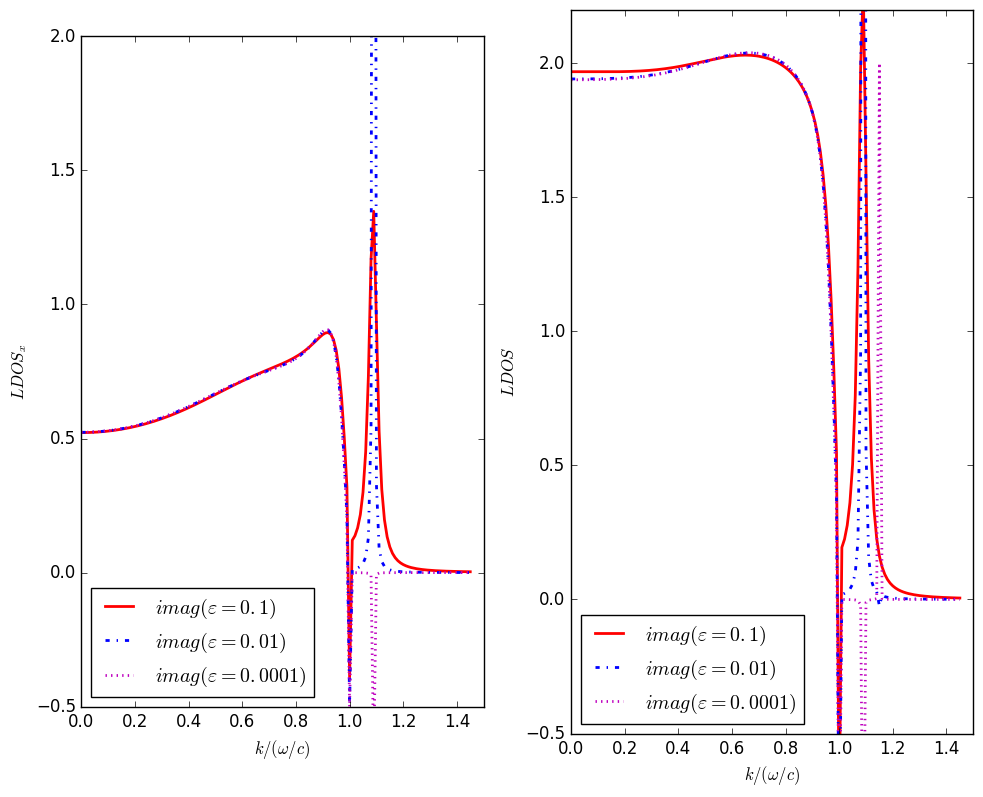

In [6]:
ldos_1 = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0.1_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
ldosqpoints_1 = ldos_1[:,[2,5,6,7,8]]
ldos_01 = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0.01_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
ldosqpoints_01 = ldos_01[:,[2,5,6,7,8]]
ldos_0001 = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0.0001_a_225_x_405_y_0_q_0_1.45_146.dat", header=false);
ldosqpoints_0001 = ldos_0001[:,[2,5,6,7,8]]
using PyPlot
#println(convert(Int64,floor(lenz/2)))
q = ldosqpoints_1[:,1]
lenx = length(q)
ldosx_1 = ldosqpoints_1[:,2]
ldosy_1 = ldosqpoints_1[:,3]
ldosz_1 = ldosqpoints_1[:,4]
ldos_av_1 = ldosqpoints_1[:,5]
ldosx_01 = ldosqpoints_01[:,2]
ldosy_01 = ldosqpoints_01[:,3]
ldosz_01 = ldosqpoints_01[:,4]
ldos_av_01 = ldosqpoints_01[:,5]
ldosx_0001 = ldosqpoints_0001[:,2]
ldosy_0001 = ldosqpoints_0001[:,3]
ldosz_0001 = ldosqpoints_0001[:,4]
ldos_av_0001 = ldosqpoints_0001[:,5]


fig = figure("LDOS q plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
cp = ax[:plot](q, ldosx_1, "r-", linewidth=2.0)
cp = ax[:plot](q, ldosx_01, "b-.", linewidth=2.0)
cp = ax[:plot](q, ldosx_0001, "m:", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS_x")
axis("image")
xlim(-0.0,1.5)
ylim(-0.5,2)
tight_layout()
gcf() # Needed for IJulia to plot inline
legend([L"imag(\varepsilon=0.1)",L"imag(\varepsilon=0.01)",L"imag(\varepsilon=0.0001)"],loc="lower left")
display(maximum(abs(ldosx)))

ax = fig[:add_subplot](1,2,2)
cp = ax[:plot](q, ldos_av_1, "r-", linewidth=2.0)
cp = ax[:plot](q, ldos_av_01, "b-.", linewidth=2.0)
cp = ax[:plot](q, ldos_av_0001, "m:", linewidth=2.0)
#ax[:clabel](cp, inline=1, fontsize=5)

xlabel(L"k/(\omega/c)")
ylabel(L"LDOS")
axis("image")
xlim(-0.0,1.5)
ylim(-0.5,2.2)
tight_layout()
gcf() # Needed for IJulia to plot inline
legend([L"imag(\varepsilon=0.1)",L"imag(\varepsilon=0.01)",L"imag(\varepsilon=0.0001)"],loc="lower left")
display(maximum(abs(ldosx)))

## LDOS components as a function of dipole position

We can also plot out the LDOS's when the dipole is placed at different locations along the x-axis. Here we are using some rough parameters just for demonstration purpose.

As plotted below, the dipole is changing position from $270$nm to $572.5$nm from the origin (center of the waveguide cross section) along the x-axis. 

In [7]:
# Load the simulated data.
ldos = readdlm("data/ldos_N_1_lam_894_eps_2.1013_0_a_225_x0_270_x1_572.5_nx_14_y_0_q_0_1.45_146.dat", header=false)

2044×8 Array{Float64,2}:
 894.0  0.0   270.0    0.0   0.728056     …   0.951218      2.18821    
 894.0  0.0   293.269  0.0   0.663516         0.906824      2.07189    
 894.0  0.0   316.538  0.0   0.616015         0.881125      1.99427    
 894.0  0.0   339.808  0.0   0.580722         0.871552      1.94815    
 894.0  0.0   363.077  0.0   0.55446          0.875499      1.92758    
 894.0  0.0   386.346  0.0   0.535035     …   0.89023       1.92716    
 894.0  0.0   409.615  0.0   0.52085          0.91286       1.94165    
 894.0  0.0   432.885  0.0   0.510714         0.94045       1.96605    
 894.0  0.0   456.154  0.0   0.503705         0.970092      1.99556    
 894.0  0.0   479.423  0.0   0.4991           0.999081      2.0259     
 894.0  0.0   502.692  0.0   0.496313     …   1.02505       2.05338    
 894.0  0.0   525.962  0.0   0.494904         1.04602       2.07502    
 894.0  0.0   549.231  0.0   0.494486         1.0606        2.08869    
   ⋮                                   

In [8]:
ldosqpoints = ldos[:,[2,3,5,6,7,8]]
lenr = 14; rstart=270.; rend=572.5; 
lenq = 146; 
breakpoint = Int(floor((lenq-1)/maximum(ldosqpoints[:,1])*1.)) # The breaking point of index is chosen under the fact that the radiation contribution part takes a 1.0/max(k) space for $n_1=1.45$.
rprime = linspace(rstart,rend,lenr);
drprime = rprime[2]-rprime[1]; # Gradient of atom position vector.
ldos_rscan = zeros(lenq,5,lenr);
ldos_int = zeros(lenr,12);
ii=1;
using NumericalMath
for ri in rprime
    ind=find(abs(ldosqpoints[:,2].-ri).<drprime/2.);
    ldos_rscan[:,:,ii]=ldosqpoints[ind,[1,3,4,5,6]];
    
    ldos_x_rad = trapz(ldos_rscan[1:breakpoint,1,ii],ldos_rscan[1:breakpoint,2,ii])
    ldos_x_guide = trapz(ldos_rscan[breakpoint:end,1,ii],ldos_rscan[breakpoint:end,2,ii])
    ldos_x = ldos_x_rad+ldos_x_guide;
    ldos_y_rad = trapz(ldos_rscan[1:breakpoint,1,ii],ldos_rscan[1:breakpoint,3,ii])
    ldos_y_guide = trapz(ldos_rscan[breakpoint:end,1,ii],ldos_rscan[breakpoint:end,3,ii])
    ldos_y = ldos_y_rad+ldos_y_guide;
    ldos_z_rad = trapz(ldos_rscan[1:breakpoint,1,ii],ldos_rscan[1:breakpoint,4,ii])
    ldos_z_guide = trapz(ldos_rscan[breakpoint:end,1,ii],ldos_rscan[breakpoint:end,4,ii])
    ldos_z = ldos_z_rad+ldos_z_guide;
    ldos_rad = trapz(ldos_rscan[1:breakpoint,1,ii],ldos_rscan[1:breakpoint,5,ii])
    ldos_guide = trapz(ldos_rscan[breakpoint:end,1,ii],ldos_rscan[breakpoint:end,5,ii])
    ldos_total = ldos_rad + ldos_guide;
    
    ldos_int[ii,1]=ldos_x_rad;
    ldos_int[ii,2]=ldos_x_guide;
    ldos_int[ii,3]=ldos_x;
    ldos_int[ii,4]=ldos_y_rad;
    ldos_int[ii,5]=ldos_y_guide;
    ldos_int[ii,6]=ldos_y;
    ldos_int[ii,7]=ldos_z_rad;
    ldos_int[ii,8]=ldos_z_guide;
    ldos_int[ii,9]=ldos_z;
    ldos_int[ii,10]=ldos_rad;
    ldos_int[ii,11]=ldos_guide;
    ldos_int[ii,12]=ldos_total;
    ii+=1;
end

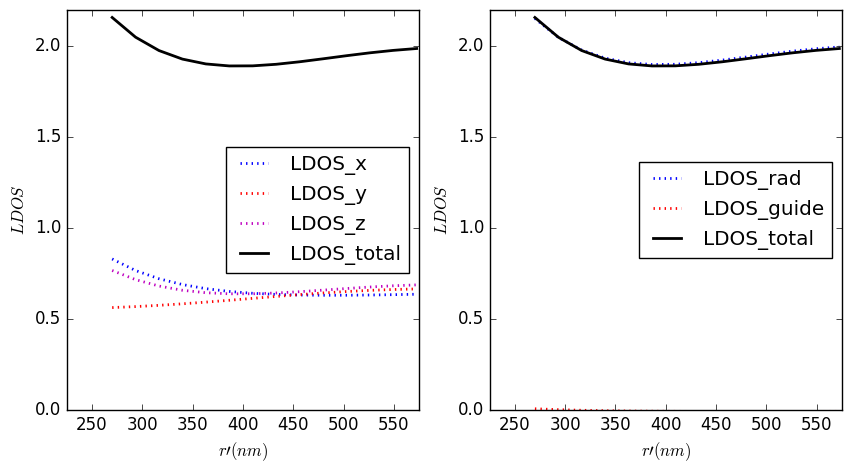

PyObject <matplotlib.legend.Legend object at 0x7f8bd7ef57d0>

In [9]:
# Plot the LDOS's.
using PyPlot
fig = figure("LDOS(r') plot",figsize=(10,5))
ax = fig[:add_subplot](1,2,1)
cp = ax[:plot](rprime, ldos_int[:,3], "b:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,6], "r:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,9], "m:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,12], "k-", linewidth=2.0)

xlabel(L"r\prime(nm)")
ylabel(L"LDOS")
ylim(-0.0,2.2)
xlim(225,575)
legend(["LDOS_x","LDOS_y","LDOS_z","LDOS_total"],loc="right")

ax = fig[:add_subplot](1,2,2)
cp = ax[:plot](rprime, ldos_int[:,10], "b:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,11], "r:", linewidth=2.0)
cp = ax[:plot](rprime, ldos_int[:,12], "k-", linewidth=2.0)

xlabel(L"r\prime(nm)")
ylabel(L"LDOS")
ylim(-0.0,2.2)
xlim(225,575)
legend(["LDOS_rad","LDOS_guide","LDOS_total"],loc="right")

The LDOS values seem larger than what I expected given $n_1=1.4496$..

## Improved method to calculate the relative decay rates

Now, we consider to only use the radiation part of LDOS from the BEM calculation while using the analytical solution of the Green's function tensor for the guided mode contribution part of the decay rate calculation.
To verify this idea, here we compare the radiation contribution part of the averaged decay rate (or when the dipole is orientated along $[1,1,1]$ direction) against our trusted results calculated from the known analytical solution on Matlab.

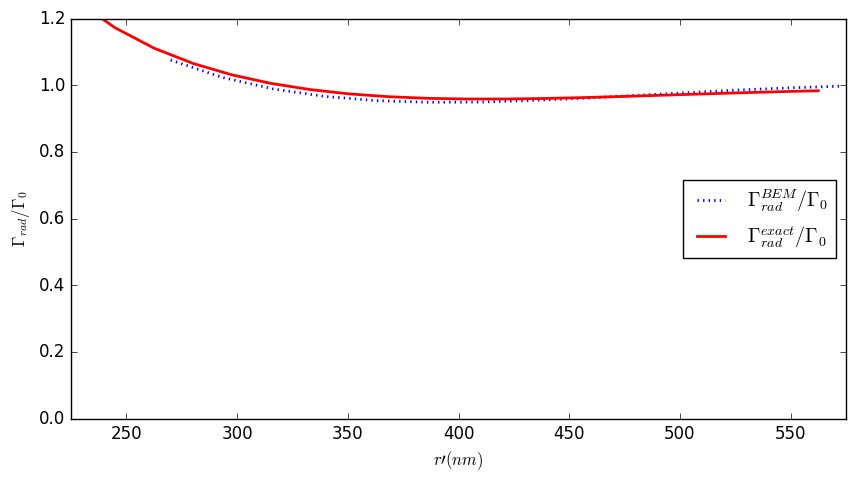

PyObject <matplotlib.legend.Legend object at 0x7f8bd6d431d0>

In [10]:
# Read data from the matlab calculation for the exact solution of un-guided mode contribution part for the averaged decay rate.
using MAT
matfile = matopen("data/nanofiber_decay_data.mat")
rp0_test=read(matfile,"rp0_test");
gamma_rad = read(matfile,"gamma_rad");
close(matfile)
# Plot both BEM and exact solution of the un-guided mode contribution to the averaged decay rate as a function of dipole position.
using PyPlot
fig = figure(L"\Gamma_{rad}/\Gamma_0(r') plot",figsize=(10,5))
ax = fig[:add_subplot](1,1,1)
cp = ax[:plot](rprime, ldos_int[:,10]/2.0, "b:", linewidth=2.0)
cp = ax[:plot](rp0_test[1,:]/1.e-9, 1+sum(gamma_rad,2), "r-", linewidth=2.0)

xlabel(L"r\prime(nm)")
ylabel(L"\Gamma_{rad}/\Gamma_0")
ylim(-0.0,1.2)
xlim(225,575)
legend([L"\Gamma_{rad}^{BEM}/\Gamma_0",L"\Gamma_{rad}^{exact}/\Gamma_0"],loc="right")

The result above shows a good agreement between the BEM method and the exact solution for the radiation mode contribution to the decay rate. 
The mismatch becomes considerable only when the dipole is very close to the surface, in which case there is a negative LDOS on the edge of the BEM calculation in the $k$-space. 
This small error may be corrected by filtering out the negative LDOS values in the $k$-space.

With the known Green's function tensor expression for the guided modes, one can hence obtain a precise enough result for the decay rates as a function of dipole orientation and atom position.